## Wprowadzenie
### Temat
Temat: “Fajnie byłoby zorientować się, w których regionach mamy za dużo ofert – psuje to rynek.”

Fakt występowania nadmiaru ofert na danym obszarze można ocenić poprzez analizę zachowania cen. Jeżeli są one niższe, niż wynikałoby to ze standardu danego lokum — określanego m.in. przez liczbę pokoi, dostępne udogodnienia czy lokalizację — oznacza to, że oferujący są zmuszeni do obniżania stawek, aby przyciągnąć potencjalnych klientów. Taka sytuacja świadczy o silnej presji cenowej, będącej efektem nadpodaży na danym rynku.

### Modelowanie uczenia maszynowego 
#### Opis
Regiony zostaną pogrupowane wykorzystując współrzędne geograficzne. Takie podejście jest bardziej precyzyjne niż wykorzystanie przypisania administracyjnego, ponieważ rzeczywiste rozłożenie regionów turystycznych nie zawsze pokrywa się z granicami administracyjnymi.

Celem modelu będzie wyliczenie ceny teoretycznej, którą  wynika bezpośrednio z cech danej kwatery. Zostanie ona porównana z rzeczywistą ceną rynkową, jeżeli jest ona niższa, być może oferta zmaga się z dużą konkurencją i próbuje przyciągnąć klienta niskimi stawkami (np. lokal wart 300 zł jest wystawiany za 200 zł, bo w okolicy jest 500 podobnych ofert). Dla każdego z wcześniej wyznaczonych regionów, zostaną policzone średnie różnice między cenami - tam gdzie są one największe możemy spodziewać się nadpodaży.

#### Defnicja zadania modelowania
**Grupowanie** - alogrytm **DBSCAN**, który na podstawie współrzędnych geograficznych znajdzie obszary o dużym zagęszczeniu obiektów w porówaniu z otoczeniem, a także odfiltruje obserwacje odstające.

**Przewidywanie ceny**: 
- Model bazowy: regresja liniowa, zastosowana jako punkt odniesienia do oceny jakości bardziej złożonych modeli.
- Model docelowy: algorytm **lasu losowego**, który dzięki zdolności do modelowania nieliniowych zależności i interakcji pomiędzy zmiennymi powinien zapewnić lepszą trafność predykcji.

Jako funkcja celu zostanie wykorzystany błąd średniokwadratowy **(MSE)**, który posłuży do optymalizacji i porównania obu rozwiązań.

#### Rankingowanie
Regiony mogą zostać pogrupowane według obliczonych różnic tworząc w ten sposób ranking nadpodaży.

## Analiza danych

#### Przegląd atrybutów

In [149]:
%load_ext autoreload
%autoreload 2

import sys
from pathlib import Path

sys.path.append(str(Path("..").resolve()))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [150]:
import pandas as pd
import matplotlib.pyplot as plt

listings = pd.read_csv("../data/raw/listings.csv")
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458 entries, 0 to 1457
Data columns (total 75 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            1458 non-null   int64  
 1   listing_url                                   1458 non-null   object 
 2   scrape_id                                     1458 non-null   int64  
 3   last_scraped                                  1458 non-null   object 
 4   source                                        1458 non-null   object 
 5   name                                          1458 non-null   object 
 6   description                                   1433 non-null   object 
 7   neighborhood_overview                         726 non-null    object 
 8   picture_url                                   1458 non-null   object 
 9   host_id                                       1458 non-null   i

#### Wybór atrybutów 
Do obliczenia przewidywanej ceny wymagane są przede wszystkim kolumny definiujące standard kwatery. 
Atrybuty związane z dostępnością, cechami gospodarza lub opiniami użytkowników mogą także mieć wpływ na zmienną objaśnianą, dlatego póki co nie zostają usunięte (jeśli późniejsza analiza wskaże, że są wtórne zostaną wykluczone). Dodatkowo można pozbyć się kolumn zawierających metadane, ponieważ są one całkowicie nieinformatywne.

Lista wybranych początkowo atrybutów znajduje się w pliku *features.py*, a zastosowanych transformacji w *transformations.py*.

In [151]:
from src.features import INITIAL_FEATURES, TARGET
from src.transformations import *

listings = select_features(listings, INITIAL_FEATURES, TARGET)
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458 entries, 0 to 1457
Data columns (total 24 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   property_type           1458 non-null   object 
 1   room_type               1458 non-null   object 
 2   accommodates            1458 non-null   int64  
 3   bathrooms               1369 non-null   float64
 4   bathrooms_text          1456 non-null   object 
 5   bedrooms                1446 non-null   float64
 6   beds                    1370 non-null   float64
 7   amenities               1458 non-null   object 
 8   description             1433 non-null   object 
 9   neighborhood_overview   726 non-null    object 
 10  neighbourhood_cleansed  1458 non-null   object 
 11  latitude                1458 non-null   float64
 12  longitude               1458 non-null   float64
 13  host_response_time      1276 non-null   object 
 14  host_response_rate      1276 non-null   

#### Atrybuty nienumeryczne

In [152]:
object_columns = listings.select_dtypes(include=["object"]).columns
for col in object_columns:
    print(f"{col}: {listings[col][0]}")

property_type: Entire condo
room_type: Entire home/apt
bathrooms_text: 1 bath
amenities: ["Host greets you", "Coffee maker: Keurig coffee machine", "Coffee", "Outlet covers", "Dishes and silverware", "Smoking allowed", "Cleaning products", "Shower gel", "Central air conditioning", "Clothing storage: wardrobe and dresser", "Hair dryer", "Refrigerator", "Essentials", "Heating", "Dedicated workspace", "Safe", "Cooking basics", "Drying rack for clothing", "Hangers", "Freezer", "Karavaki body soap", "Crib", "Hot water", "Books and reading material", "Oven", "Stove", "Blender", "Baking sheet", "Microwave", "Long term stays allowed", "Iron", "Room-darkening shades", "Bed linens", "Shampoo", "Free washer \u2013 In unit", "Dishwasher", "Smoke alarm", "Hot water kettle", "Wine glasses", "First aid kit", "Dining table", "Extra pillows and blankets", "Private patio or balcony", "Free street parking", "Kitchen", "Pack \u2019n play/Travel crib", "Carbon monoxide alarm", "Children\u2019s dinnerware",

#### *property_type* i *room_type*

In [153]:
listings["property_type"].isna().sum()

np.int64(0)

In [154]:
listings["property_type"].value_counts()

property_type
Entire rental unit                    948
Entire condo                          300
Private room in rental unit            39
Entire home                            32
Entire serviced apartment              32
Room in aparthotel                     20
Room in hotel                          19
Entire loft                            11
Private room in condo                  10
Room in boutique hotel                  7
Room in serviced apartment              6
Private room in home                    5
Private room in serviced apartment      4
Entire villa                            4
Private room in guest suite             4
Private room in guesthouse              3
Entire townhouse                        3
Entire guesthouse                       2
Shared room in hostel                   2
Tiny home                               1
Private room in hostel                  1
Entire guest suite                      1
Camper/RV                               1
Shared room in condo

W celu ograniczenia szumu wynikającego z wielu wartości w kolumnie property type, wartości zostały zgeneralizowane do kilku podstawowych kategorii. Pondato został dodany nowy atrybut (*is_luxury*), który wskazuje czy dane lokum jest luksusowe. Taki atrybut może być silnie skorelowany z ceną.

In [155]:
listings = add_is_luxury_attribute(listings)
listings["is_luxury"].value_counts()

is_luxury
0    1436
1      22
Name: count, dtype: int64

<Axes: ylabel='count'>

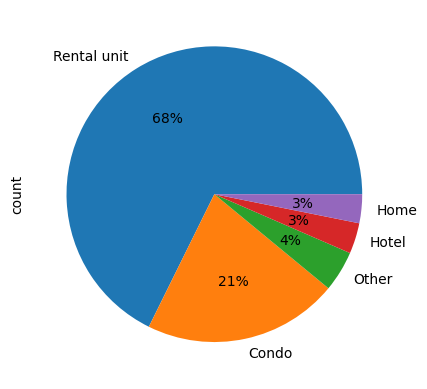

In [156]:
listings = aggregate_property_type(listings)
listings["property_type"].value_counts().plot(kind="pie", autopct="%1.0f%%")

Atrybut *room_type* pozostaje bez zmian, jest już wystarczająco dobrze podzielony na podgrupy. 

In [157]:
listings["room_type"].isna().sum()

np.int64(0)

In [158]:
listings["room_type"].value_counts()

room_type
Entire home/apt    1347
Private room         95
Hotel room           13
Shared room           3
Name: count, dtype: int64

#### *bathrooms_text* i *bathrooms*

Puste wartości w *bathrooms* zostały uzupełnione biorąc dane z *bathrooms_text* - tam braków jest zdecydowanie mniej. Ponadto dodano nowy atrybut *is_bathroom_shared*, który został wyłuskany z tekstu. Po przetworzeniu danych w *bathroom_text* ten atrybut może zostać całkowicie usunięty, nie niesie żadnej nowej informacji.

In [159]:
print(listings["bathrooms_text"].isna().sum())
print(listings["bathrooms"].isna().sum())

2
89


In [160]:
listings = fill_bathrooms_values_from_text(listings)
print(listings["bathrooms_text"].isna().sum())
print(listings["bathrooms"].isna().sum())

2
1


In [161]:
listings = add_is_bathroom_shared_attribute(listings)
listings["is_bathroom_shared"].value_counts()

is_bathroom_shared
0    1413
1      45
Name: count, dtype: int64

In [162]:
listings = drop_bathroom_text_column(listings)

#### *price* 

In [163]:
listings["price"].isna().sum()

np.int64(0)

In [164]:
listings["price"].head()

0     $80.00
1    $250.00
2    $175.00
3    $190.00
4    $210.00
Name: price, dtype: object

In [165]:
listings = convert_price_to_number(listings)
listings["price"].head()

0     80.0
1    250.0
2    175.0
3    190.0
4    210.0
Name: price, dtype: float64

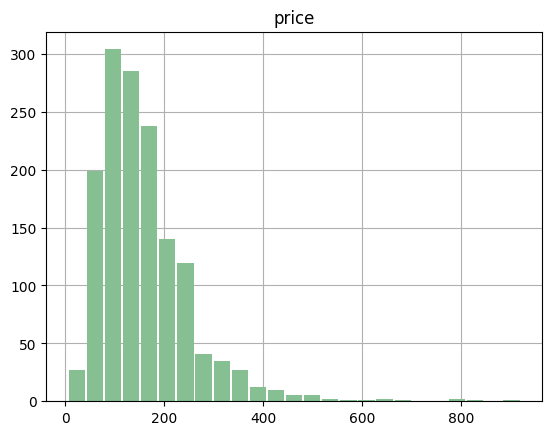

In [166]:
hist = listings.hist(bins=25, column="price", color="#86bf91", zorder=2, rwidth=0.9)

W celu minimalizacji znaczenia outlinerów (ceny mocno odbiegające od średniej) zastosowano skalowanie logarytmiczne, które ustabilizuje proces uczenia.

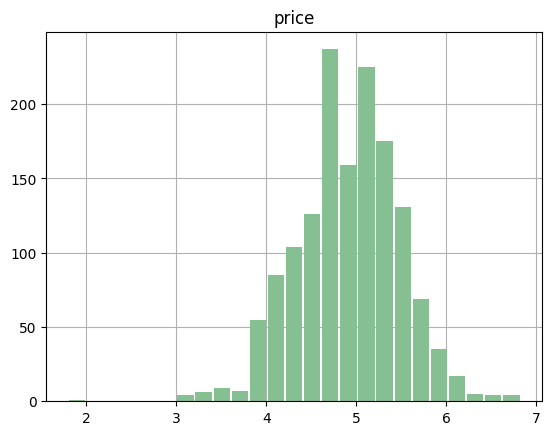

In [167]:
listings = transform_price(listings)
hist = listings.hist(bins=25, column="price", color="#86bf91", zorder=2, rwidth=0.9)

In [168]:
listings["price"].describe()

count    1458.000000
mean        4.910746
std         0.565203
min         1.791759
25%         4.564348
50%         4.948760
75%         5.278115
max         6.825460
Name: price, dtype: float64

#### *amenities*

In [169]:
listings["amenities"].isna().sum()

np.int64(0)

In [170]:
listings["amenities"].head(10)

0    ["Host greets you", "Coffee maker: Keurig coff...
1    ["Luggage dropoff allowed", "Dishes and silver...
2    ["Host greets you", "Coffee", "Dishes and silv...
3    ["Coffee", "Dishes and silverware", "Cleaning ...
4    ["Host greets you", "Coffee", "Dishes and silv...
5    ["Host greets you", "Coffee", "Dishes and silv...
6    ["Dishes and silverware", "Hair dryer", "Refri...
7    ["Dishes and silverware", "Toaster", "Exercise...
8    ["Host greets you", "Dishes and silverware", "...
9    ["Coffee maker: drip coffee maker, espresso ma...
Name: amenities, dtype: object

In [171]:
from src.amenities_correlation import get_unique_amenities

unique = get_unique_amenities(listings)

print(f'Unique amenities: {len(unique)}')

Unique amenities: 882


Z uwagi na bardzo dużą liczbę unikalnych udogodnień zostanie wybranych **10**, które:
- wyglądają wymiernie (ocena subiektywna). 
- mają dużą korelację Spearmana z kolumną `price`.
- występują w minimum **50** obiektach.

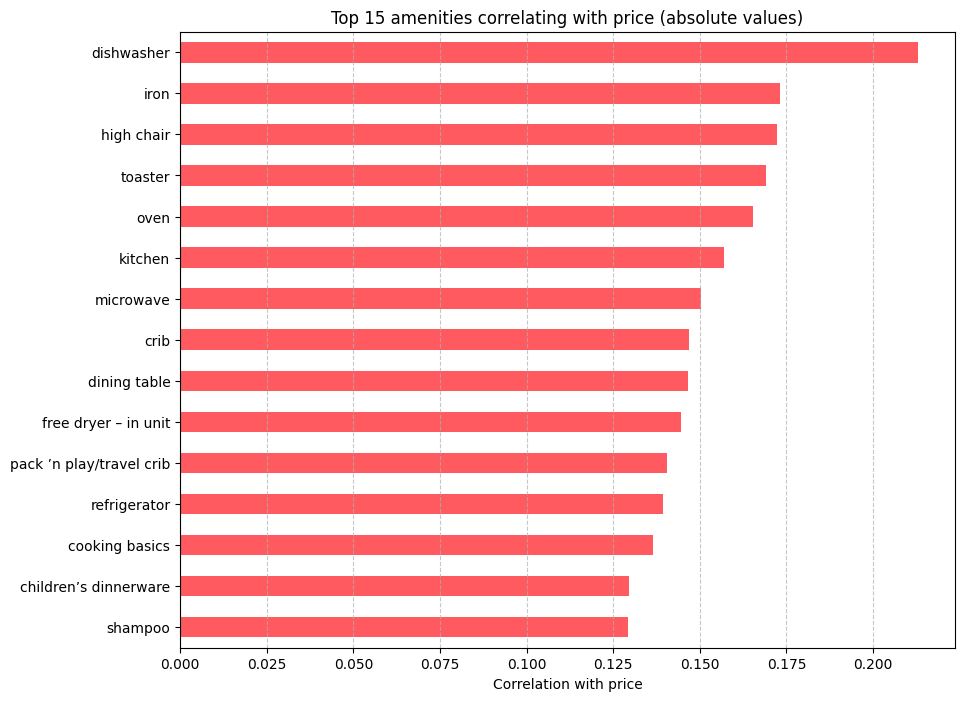

In [172]:
from src.amenities_correlation import calc_amenities_correlation

amenities_correlation_df = calc_amenities_correlation("../data/raw/listings.csv", min_freq=50)
amenities_correlation_df = amenities_correlation_df.abs()

top_15 = amenities_correlation_df.sort_values(ascending=False).head(15)
top_15.sort_values(ascending=True).plot(
    kind='barh',
    figsize=(10, 8),
    color='#FF5A5F',
    title='Top 15 amenities correlating with price (absolute values)'
)
plt.xlabel('Correlation with price')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

Finalnie wybrane udogodnienia to:

In [173]:
from src.features import AMENITIES

print(AMENITIES)

['dishwasher', 'iron', 'toaster', 'oven', 'kitchen', 'microwave', 'crib', 'dining table', 'Free dryer – In unit', 'Pack ’n play/Travel crib']


Zostaną one zakodowane binarnie metodą `one-hot encoding`.

In [174]:
listings = encode_amenities_one_hot(listings)
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458 entries, 0 to 1457
Data columns (total 34 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   property_type                     1458 non-null   object 
 1   room_type                         1458 non-null   object 
 2   accommodates                      1458 non-null   int64  
 3   bathrooms                         1457 non-null   float64
 4   bedrooms                          1446 non-null   float64
 5   beds                              1370 non-null   float64
 6   description                       1433 non-null   object 
 7   neighborhood_overview             726 non-null    object 
 8   neighbourhood_cleansed            1458 non-null   object 
 9   latitude                          1458 non-null   float64
 10  longitude                         1458 non-null   float64
 11  host_response_time                1276 non-null   object 
 12  host_r

In [175]:
print(listings["amenity_free_dryer_-_in_unit"].value_counts())

amenity_free_dryer_-_in_unit
0    1360
1      98
Name: count, dtype: int64
